In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import functions as fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import os
import time
from skimage.morphology import binary_dilation
import json
import sys
from tqdm import tqdm
import pandas as pd

In [2]:
para_list=[]
for i in range(10):
      para_list.append({'OutDIR': f'/DATA/vito/output/ran_synth/ran_synth_{i:02}_dw4_cp1024_3b/',
                        'DataDIR': '/DATA/vito/data/',
                        'DatasetName': 'ran_synth/img/*',
                        'fid': i,
                        'crop_size': 1024,
                        'resample_factor': 1/4,
                        'point_per_side': 30,
                        'dilation_size':15,
                        'b':100,
                        'stability_t':0.85,
                        'third_b_resample_factor':1/10, #None: use method A. 1: auto select resample rate.
                        'resolution(mm)': 0.2,
                        'expected_min_size(sqmm)': 100,
                        'min_radius': 10
                        }
                        )


In [20]:
init_para=para_list[4]
OutDIR=init_para.get('OutDIR')
DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')
resample_factor=init_para.get('resample_factor')
b=init_para.get('b')
crop_size=init_para.get('crop_size')

image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)
if resample_factor!=1:
    pre_para={'Resample': {'fxy':resample_factor},
        #'Gaussian': {'kernel size':3}
        #'CLAHE':{'clip limit':2}#,
        #'Downsample': {'fxy':4},
        #'Buffering': {'crop size': crop_size}
        }

    image_dw=fnc.preprocessing_roulette(image, pre_para)
    print('resampled to: ', image.shape)

ar_masks=np.array(np.load(OutDIR+'Third/all_mask_third_pass_id.npy', allow_pickle=True))

print('masks size:', ar_masks.shape)
print(len(np.unique(ar_masks)),' mask(s) loaded')


img_04.npy imported
Image size: (20000, 20000, 3)
resampled to:  (20000, 20000, 3)
masks size: (5000, 5000)
1668  mask(s) loaded


In [21]:
fn_img = glob.glob(DataDIR+DSname[:-5]+'msk/*')
fn_img.sort()
mask=(np.load(fn_img[fid])).astype(np.uint16)
mask_dw=fnc.resample_fnc(mask,{'target_size':image_dw.shape[:-1][::-1], 'method':'nearest'})
ar_masks_rs=fnc.resample_fnc(ar_masks.astype(np.uint16),{'target_size':mask.shape[::-1], 'method':'nearest'})
print(fn_img[fid].split("/")[-1]+' imported')
print('No. of objects: '+str(len(np.unique(mask))-1))
print('resampled shape: ', mask_dw.shape)

msk_04.npy imported


No. of objects: 3897
resampled shape:  (5000, 5000)


(np.float64(-0.5), np.float64(19999.5), np.float64(19999.5), np.float64(-0.5))

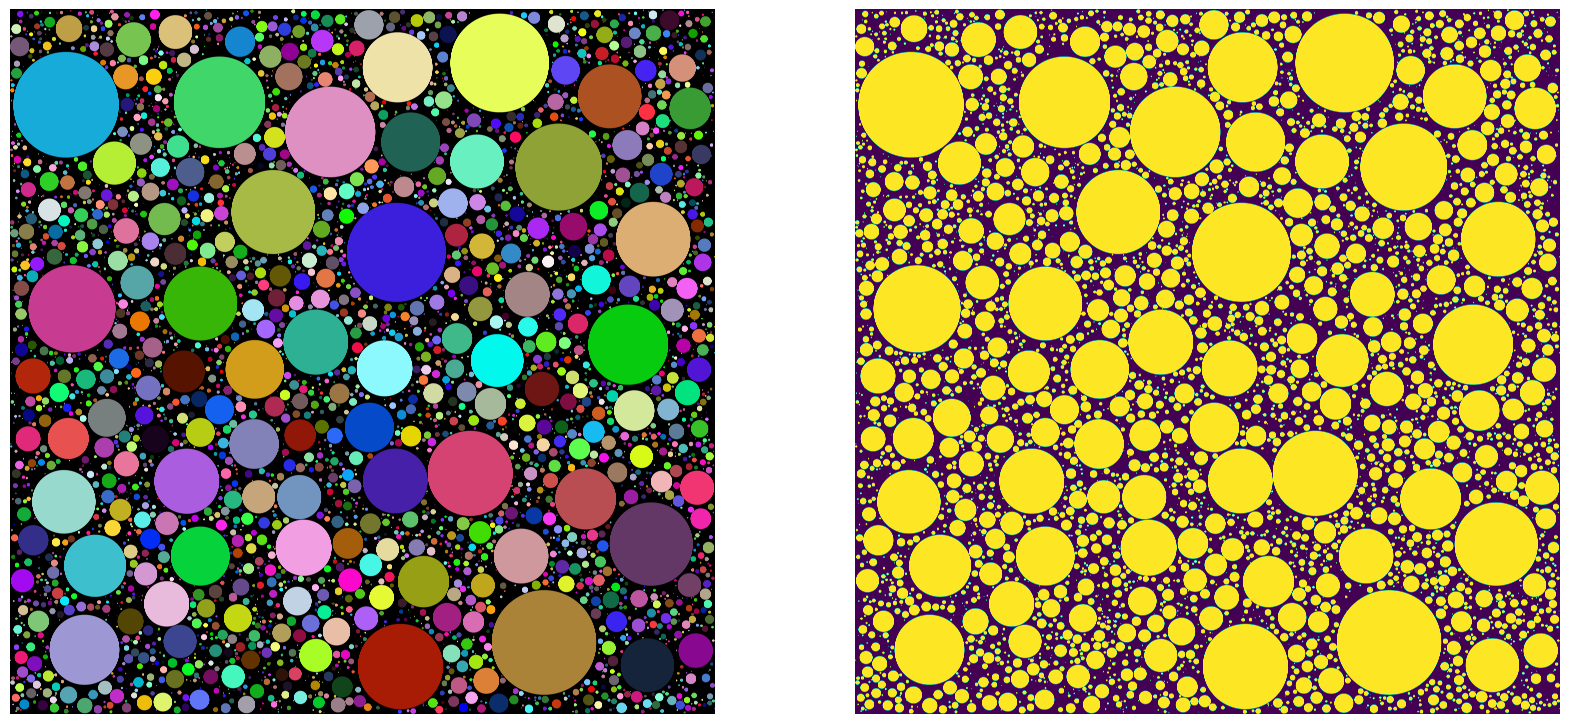

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask>0)
plt.axis('off')

In [24]:
centroids=[fnc.get_centroid(ar_masks==id) for id in np.unique(ar_masks)]
centroids=np.array(centroids)/resample_factor

In [26]:
ids, counts=np.unique(mask, return_counts=True)

ids, counts = ids[1:], counts[1:]
area = counts * (0.2 * 0.2)

ids = ids[np.argsort(area)]
counts = counts[np.argsort(area)]
area = np.sort(area)

In [27]:
counts

array([    197,     197,     197, ..., 6201441, 6927789, 7059001])

In [28]:
area

array([7.8800000e+00, 7.8800000e+00, 7.8800000e+00, ..., 2.4805764e+05,
       2.7711156e+05, 2.8236004e+05])

In [40]:
#point based
point_based_ac=np.zeros_like(ids)

for i in range(len(centroids))[1:]:
    hit_id=int(mask[int(centroids[i][0]),int(centroids[i][1])])
    point_based_ac[ids==hit_id]+=1

np.save(OutDIR+'point_based_ac.npy', [point_based_ac,area])

In [31]:
np.nonzero(point_based_ac)

(array([1815, 2136, 2171, ..., 3894, 3895, 3896]),)

In [34]:
counts[1815], area[1815], ids[1815]

(np.int64(6625), np.float64(265.00000000000006), np.uint16(1161))

In [41]:
np.unique(point_based_ac, return_counts=True)

(array([0, 1], dtype=uint16), array([2231, 1666]))

In [37]:
#mask iou ac
mask_ious=np.zeros_like(ids).astype(np.float64)
for i in range(len(centroids))[1:]:
    hit_id=int(mask[int(centroids[i][0]),int(centroids[i][1])])
    current_iou=mask_ious[ids==hit_id]
    iou=fnc.iou(ar_masks_rs==i, mask==hit_id)
    if iou>current_iou:
        mask_ious[ids==hit_id]=iou

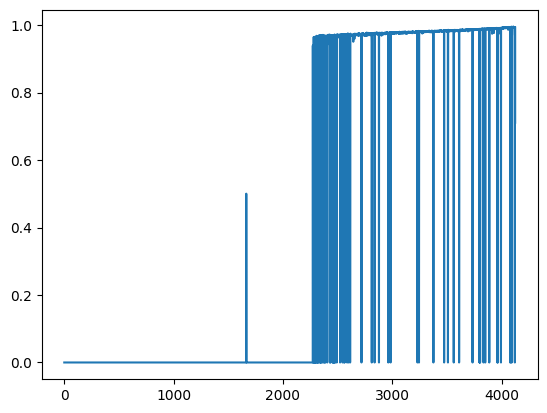

In [38]:
plt.plot(mask_ious)

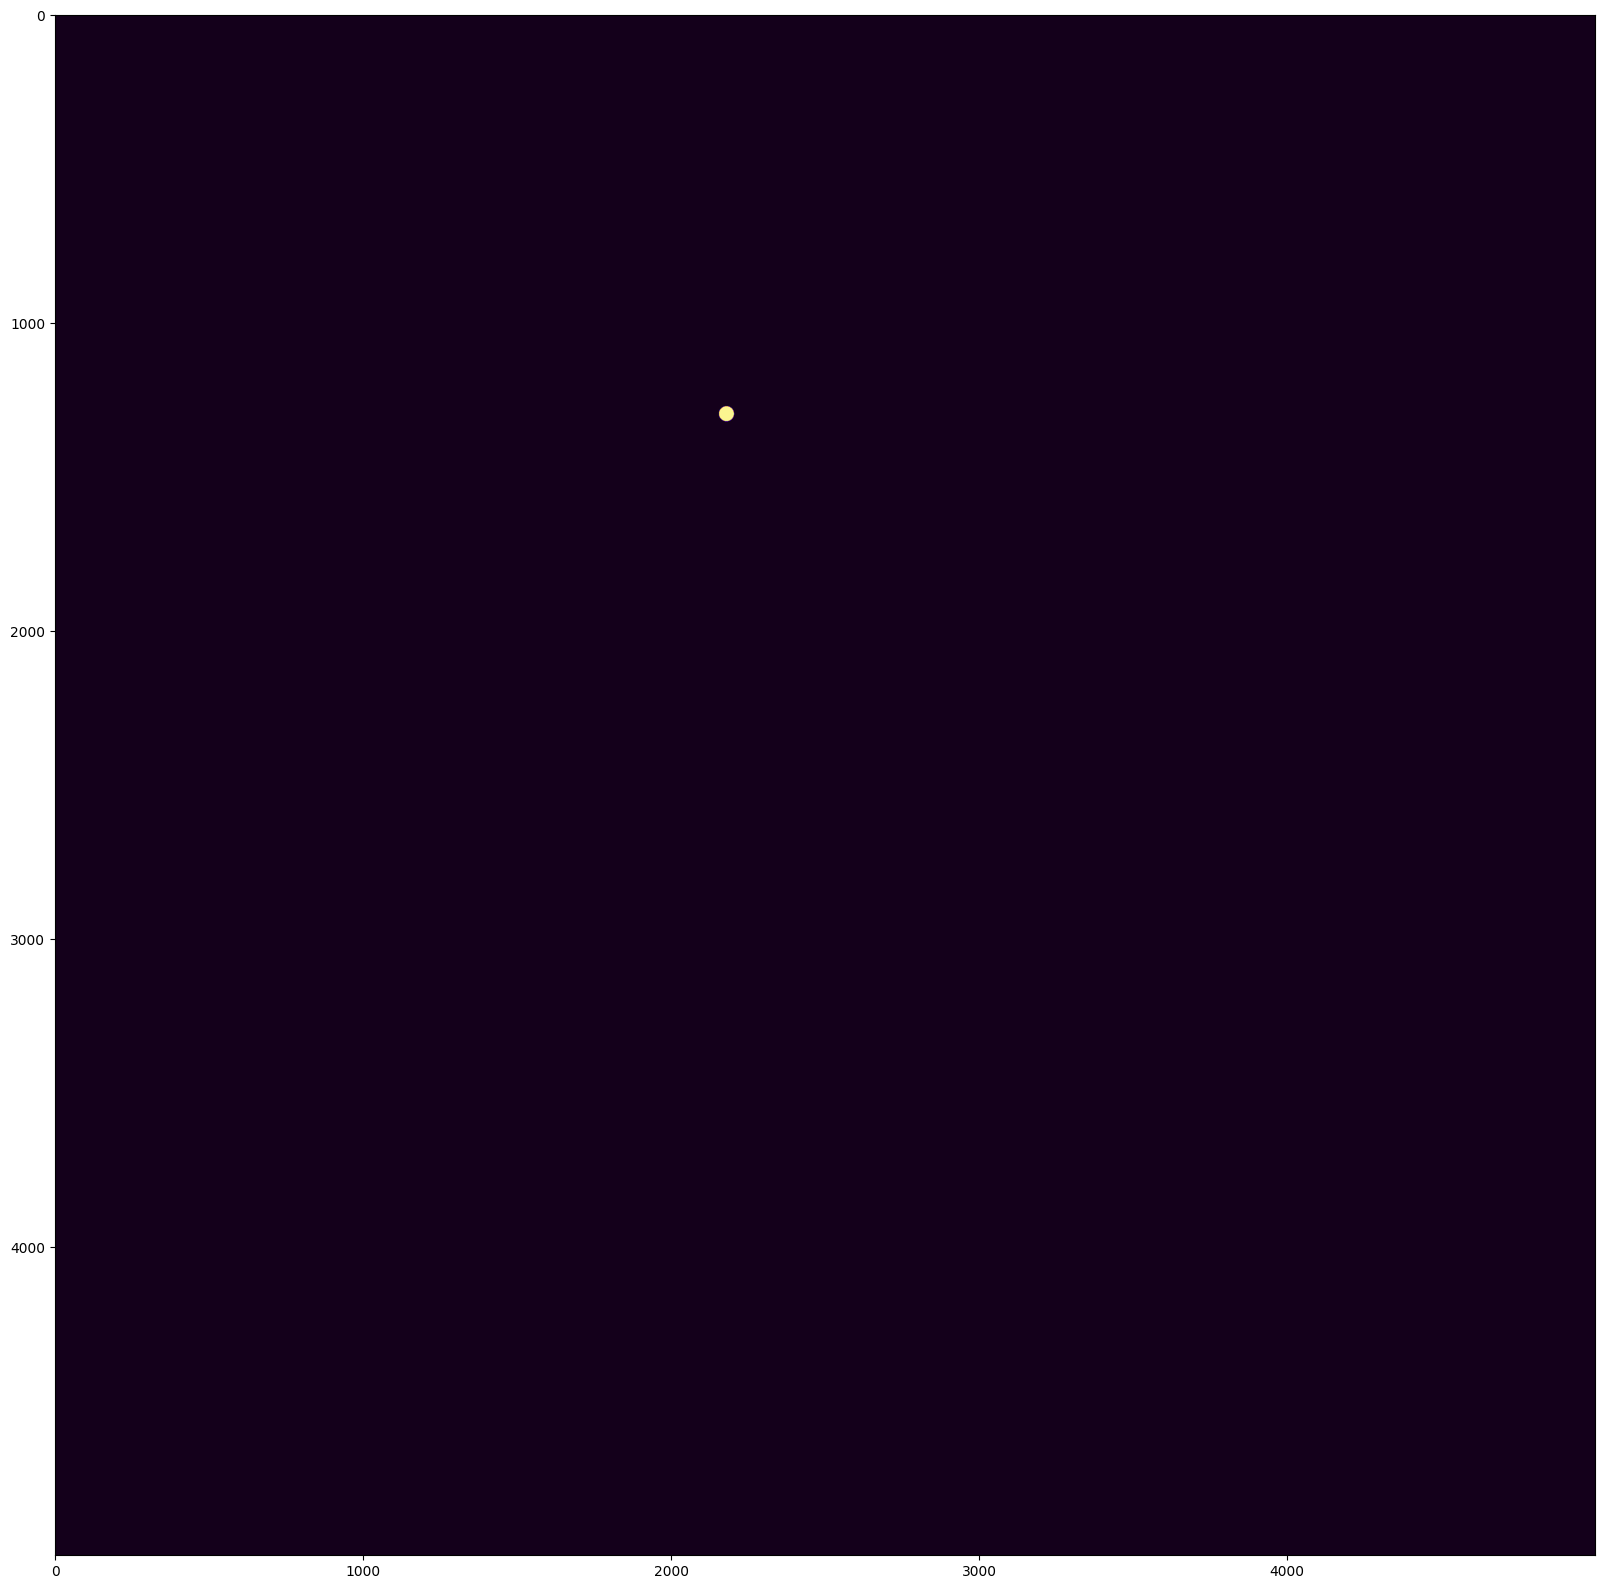

In [45]:
plt.figure(figsize=(20,20))
plt.imshow(mask_dw==24462, cmap='magma')
#plt.show()
#plt.figure(figsize=(20,20))
plt.imshow(ar_masks==1,alpha=0.3)

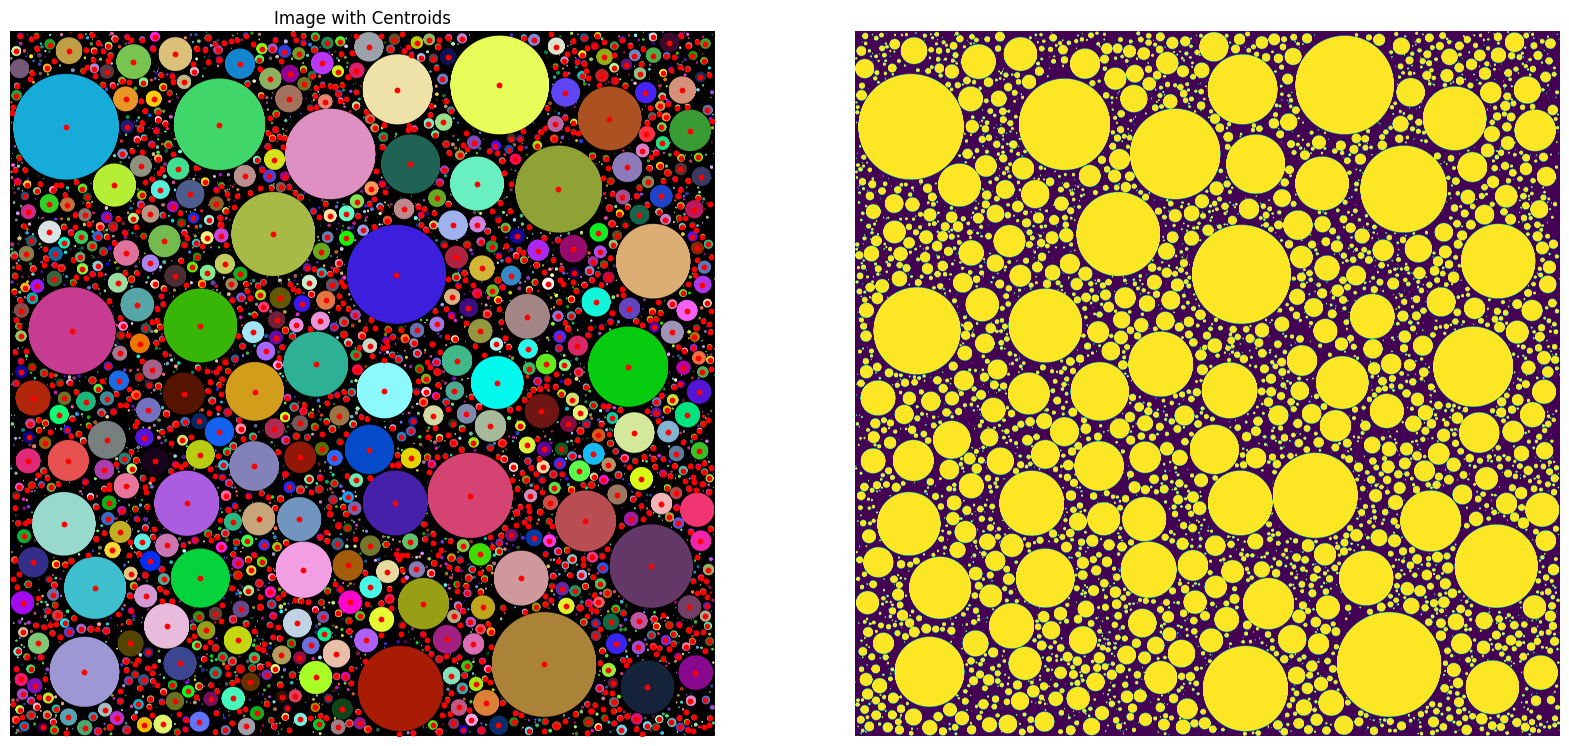

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image)

plt.scatter(centroids[1:, 1], centroids[1:, 0], color='red', s=10, label='Centroids')

plt.title('Image with Centroids')

plt.subplot(1,2,2)
plt.imshow(mask>0)
plt.axis('off')

plt.show()